**Main imports**

In [1]:
# Main Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import itertools
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Import dataset**

In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
               'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
               'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup',
               'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house',
               'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster',
               'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid',
               'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
               'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew',
               'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower',
               'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
               'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm', ]

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
    batch_size=32, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
    batch_size=32, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


**View some of the test dataset**

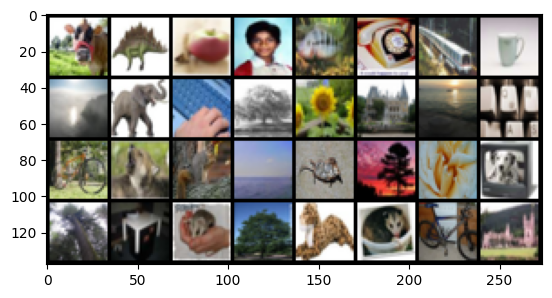

In [3]:
# let's view some of the training data
plt.rcParams['figure.dpi'] = 100
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
plt.imshow(torchvision.utils.make_grid(x).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
plt.show()

**Model for DCGAN, with optimisers**

In [4]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)

# Instantiate the generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Calculate the total number of parameters for the generator and discriminator
total_params_generator = sum(p.numel() for p in generator.parameters())
total_params_discriminator = sum(p.numel() for p in discriminator.parameters())
total_params_dcgan = total_params_generator + total_params_discriminator

print(f"Total number of parameters for the generator: {total_params_generator}")
print(f"Total number of parameters for the discriminator: {total_params_discriminator}")
print(f"Total number of parameters for the DCGAN: {total_params_dcgan}")

# Check if the total number of parameters exceeds 1,000,000
if total_params_dcgan > 1000000:
    print("Warning: The total number of parameters exceeds 1,000,000.")
    
# Define hyperparameters
lr = 0.0002
beta1 = 0.5
batch_size = 64
image_size = 64
num_epochs = 10

# Loss function and optimizer
criterion = nn.BCELoss()
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

total_steps = 0

Total number of parameters for the generator: 370624
Total number of parameters for the discriminator: 167808
Total number of parameters for the DCGAN: 538432


**Main training loop**

In [5]:
# Training loop
while total_steps < 50000:
    for i, data in enumerate(train_loader, 0):
        if total_steps >= 50000:
            break
        
        # Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        discriminator.zero_grad()
        real_images, _ = data
        real_images = real_images.to(device)
        b_size = real_images.size(0)
        real_labels = torch.ones(b_size, device=device)
        output_real = discriminator(real_images).view(-1)
        loss_D_real = criterion(output_real, real_labels)
        loss_D_real.backward()

        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(b_size, device=device)
        output_fake = discriminator(fake_images.detach()).view(-1)
        loss_D_fake = criterion(output_fake, fake_labels)
        loss_D_fake.backward()
        optimizerD.step()

        # Update Generator: maximize log(D(G(z)))
        generator.zero_grad()
        output = discriminator(fake_images).view(-1)
        loss_G = criterion(output, real_labels)
        loss_G.backward()
        optimizerG.step()

        total_steps += 1

        # Print statistics
        if total_steps % 100 == 0:
            print(f'Step [{total_steps}/{50000}], '
                  f'D_loss_real: {loss_D_real.item():.4f}, '
                  f'D_loss_fake: {loss_D_fake.item():.4f}, '
                  f'G_loss: {loss_G.item():.4f}')

Step [100/50000], D_loss_real: 0.3545, D_loss_fake: 0.0010, G_loss: 5.8563
Step [200/50000], D_loss_real: 0.2634, D_loss_fake: 0.1800, G_loss: 2.0553
Step [300/50000], D_loss_real: 0.0182, D_loss_fake: 0.1539, G_loss: 3.9533
Step [400/50000], D_loss_real: 0.0824, D_loss_fake: 0.3011, G_loss: 3.1677
Step [500/50000], D_loss_real: 0.1149, D_loss_fake: 0.1865, G_loss: 2.9797
Step [600/50000], D_loss_real: 0.2701, D_loss_fake: 0.1253, G_loss: 2.2771
Step [700/50000], D_loss_real: 0.1151, D_loss_fake: 0.3012, G_loss: 2.9310
Step [800/50000], D_loss_real: 0.2427, D_loss_fake: 0.1403, G_loss: 1.9061
Step [900/50000], D_loss_real: 0.3610, D_loss_fake: 0.2110, G_loss: 2.2073
Step [1000/50000], D_loss_real: 0.2487, D_loss_fake: 0.3639, G_loss: 2.8377
Step [1100/50000], D_loss_real: 0.2214, D_loss_fake: 0.1401, G_loss: 2.2202
Step [1200/50000], D_loss_real: 0.2263, D_loss_fake: 0.6497, G_loss: 2.1544
Step [1300/50000], D_loss_real: 1.0060, D_loss_fake: 0.0803, G_loss: 1.1638
Step [1400/50000], D_

**Latent interpolations**

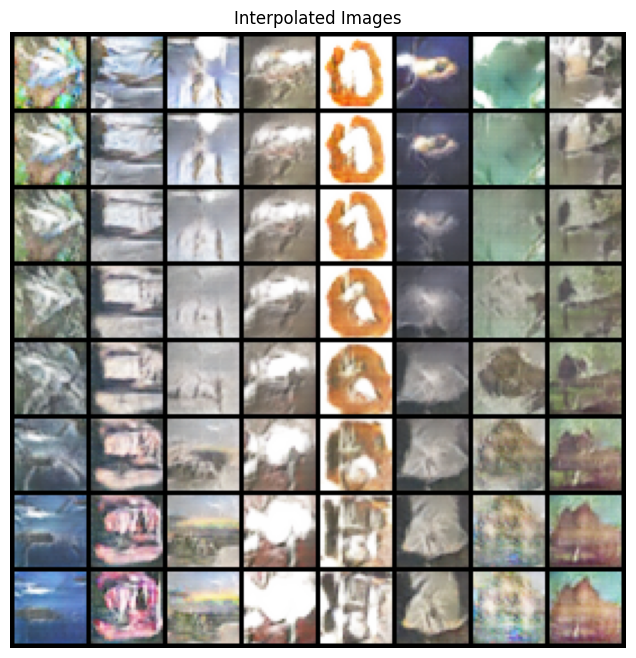

In [6]:
col_size = int(np.sqrt(batch_size))

# Define latent space dimensionality
latent_dim = 100

# Sample latent vectors z for the top and bottom rows
z0 = torch.randn(col_size, latent_dim, device=device).repeat(col_size, 1)
z1 = torch.randn(col_size, latent_dim, device=device).repeat(col_size, 1)

# Linearly interpolate between the sampled latent vectors
t = torch.linspace(0, 1, col_size).unsqueeze(1).repeat(1, col_size).view(-1, 1).to(device)
lerp_z = (1 - t) * z0 + t * z1

# Reshape lerp_z to include the batch dimension
lerp_z = lerp_z.view(col_size * col_size, latent_dim, 1, 1)

# Sample from the generator using the interpolated latent vectors
with torch.no_grad():
    lerp_images = generator(lerp_z).detach().cpu()

# Visualize the interpolated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Interpolated Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(lerp_images, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()               

**FID Score**

In [7]:
%%capture
!pip install clean-fid
import os
import torch
from cleanfid import fid
from torchvision.utils import save_image

In [8]:
###################
# Define directories
real_images_dir = 'real_images'
generated_images_dir = 'generated_images'
num_samples = 10000 # Do not change

# Create/clean the directories
def setup_directory(directory):
    if os.path.exists(directory):
        !rm -r {directory}
    os.makedirs(directory)

setup_directory(real_images_dir)
setup_directory(generated_images_dir)

# Generate and save 10k model samples
num_generated = 0
while num_generated < num_samples:
    # Sample from your model, you can modify this
    z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    samples_batch = generator(z).cpu().detach()

    for idx, image in enumerate(samples_batch):
        if num_generated >= num_samples:
            break
        save_image(image, os.path.join(generated_images_dir, f"gen_img_{num_generated}.png"))
        num_generated += 1
        # Save a few generated images for comparison
        if idx < 5:
            save_image(image, f"gen_img_{num_generated}_{idx}.png")

# Save 10k images from the CIFAR-100 test dataset
num_saved_real = 0
while num_saved_real < num_samples:
    real_samples_batch, _ = next(test_iterator)
    for idx, image in enumerate(real_samples_batch):
        if num_saved_real >= num_samples:
            break
        save_image(image, os.path.join(real_images_dir, f"real_img_{num_saved_real}.png"))
        num_saved_real += 1
        # Save a few real images for comparison
        if idx < 5:
            save_image(image, f"real_img_{num_saved_real}_{idx}.png")

In [9]:
# Compute FID
score = fid.compute_fid(real_images_dir, generated_images_dir, mode="clean")
print(f"FID score: {score}")

compute FID between two folders


/home2/wgmd33/myjupyterenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Found 10000 images in the folder real_images


FID real_images : 100%|██████████| 313/313 [01:27<00:00,  3.56it/s]


Found 10000 images in the folder generated_images


FID generated_images : 100%|██████████| 313/313 [01:05<00:00,  4.78it/s]


FID score: 66.49314750209737


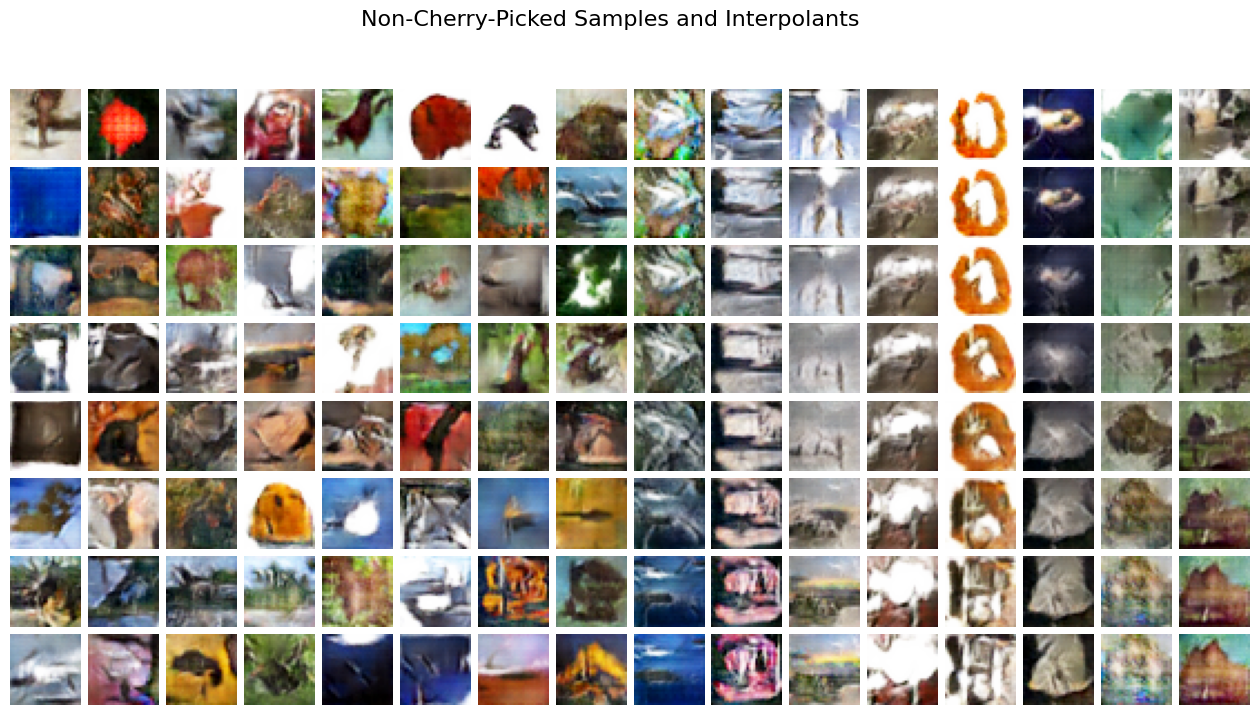

In [20]:
import torch

# Define function to plot 8x8 grid of images
def plot_image_grid(samples_images, lerp_images, title):
    fig, axes = plt.subplots(8, 16, figsize=(16, 8))
    fig.suptitle(title, fontsize=16)
    for i in range(8):
        # Plot non-cherry-picked samples
        for j in range(8):
            ax = axes[i, j]
            image = samples_images[i * 8 + j].permute(1, 2, 0)
            ax.imshow(torch.clamp(image, 0, 1))  # Normalize pixel values to [0, 1]
            ax.axis('off')
        # Plot interpolants
        for j in range(8, 16):
            ax = axes[i, j]
            image = lerp_images[i * 8 + j - 8].permute(1, 2, 0)
            ax.imshow(torch.clamp(image, 0, 1))  # Normalize pixel values to [0, 1]
            ax.axis('off')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# Plot non-cherry-picked samples and interpolants side by side
plot_image_grid(samples_batch[:64], lerp_images, "Non-Cherry-Picked Samples and Interpolants")